In [ ]:
!pip install gymnasium

In [ ]:
import numpy as np
import pygame
import gymnasium as gym
from gymnasium import Env
import torch
import torch.nn as nn
from torch.nn import functional as F

class One_Dimentional_Lander(Env):
    START_FUEL = 5
    THRUST = 2
    AG = 1
    FUEL_COST = 1
    HEIGHT = 10 # elevation
    # MAX_START_VY = 0.0
    # MIN_START_VY = 0.0
    # MAX_START_Y = 100.0
    # MIN_START_Y = 10.0

    def __init__(self, y=HEIGHT, vy=0, fuel=START_FUEL, thrust=THRUST, g=AG):
        self.state = [y, vy, fuel] # elevation, velocity, fuel
        self.thrust = thrust
        self.ag = g

    def compute_fire_state(self):
        y = self.state[0] + self.state[1] + 0.5 * (self.thrust - self.ag) # integral
        vy = self.state[1] + (self.thrust - self.ag)
        fuel = self.state[2] - 1
        return [y, vy, fuel]
        # elevation ()
        # speed - time * 1 = 0
        # speed = 10
        # need around 10
        # elevation:

    def compute_sink_state(self):
        y = self.state[0] + self.state[1] + 0.5 * (0 - self.ag) # integral of velocity over time, time = 1, sqrt root
        vy = self.state[1] + (0 - self.ag)
        fuel = self.state[2]
        return [y, vy, fuel]

    def landed(self):
        return self.state[0] <= 0

    def compute_reward(self):
        if not self.landed():
            return 0.0
        else:
            return (self.state[2] * self.FUEL_COST) + self.state[1] ** 3 # (fuel * unit_cost) + velocity^3
            # speed, if up, positive
            # state has 3 elements, indicating elevation, speed, fuel

    def out_of_fuel(self):
        return self.state[2] <= 0

    def step(self, action):
        if self.out_of_fuel() or action == 0:
            self.state = self.compute_sink_state()
        else:
            self.state = self.compute_fire_state()

        done = self.landed()
        reward = self.compute_reward()
        return self.state, reward, done, {} # API

    def render(self):
        pass


    def reset(self, h=-1, vy=-1, fuel=-1, seed=42):
        # set the altitude, velocity, and fuel to random values within the specified ranges that are floats
        super().reset(seed=seed)
        np.random.seed(seed)
        self.state[0] = 10 # elevation
        self.state[1] = 0 # velocity
        self.state[2] = 5 # fuel
        # if h == -1:
        #     self.state[0] = np.random.uniform(self.MIN_START_Y, self.MAX_START_Y)
        # else:
        #     self.state[0] = h
        # if vy == -1:
        #     self.state[1] = np.random.uniform(self.MIN_START_VY, self.MAX_START_VY)
        # else:
        #     self.state[1] = vy
        # if fuel == -1:
        #     self.state[2] = self.START_FUEL
        # else:
        #     self.state[2] = fuel
        print(f'reset state to {self.state}')
        return self.state, None

  # def func():
  #   # turn on engine only after speed is 10
  #   elevation = 20
  #   acceleration = (-2 + 1)

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
discount_factor = 0.9

In [ ]:
# create a hash table
# copy the state, run two actions with this state. Does it land? If not, call recursively.
# discount and return
# look at the table
# before running, check the table.
# we have 4 input states
d = {}
def create_hash_table(elevation, velocity, fuel, action):

  key = (elevation, velocity, fuel, action)
  if key in d:
    return d[key]
  # value_of_the_action
  # fire
  return 0


In [ ]:
# try both actions
import copy
display_cnt = 0

def recursion(env):
  global display_cnt
  copied_env = copy.deepcopy(env)

  next_state, reward_1, done, _ = env.step(1) # fire
  if not done:
    reward_1 = recursion(env) * discount_factor

  next_state, reward_0, done, _ = copied_env.step(0) # not fire
  if not done:
    reward_0 = recursion(copied_env) * discount_factor

  reward = max(reward_1, reward_0)
  # if display_cnt <= 100:
  #   display_cnt += 1
    #print(f'env={env.state}, reward={reward}')
  return reward

In [ ]:
# try both actions
import copy
display_cnt = 0

# memo = {}

def dp(env):
  global display_cnt
  copied_env = copy.deepcopy(env)
  key_1 = tuple(env.state + [1])
  if key_1 in memo:
    reward_1 = memo[key_1]
  else:
    next_state, reward_1, done, _ = env.step(1) # fire
    if not done:
      reward_1 = dp(env) * discount_factor
    memo[key_1] = reward_1

  key_0 = tuple(copied_env.state + [0])
  if key_0 in memo:
    return memo[key_0]
  else:
    next_state, reward_0, done, _ = copied_env.step(0) # not fire
    if not done:
      reward_0 = dp(copied_env) * discount_factor
    memo[key_0] = reward_0

  reward = max(reward_1, reward_0)
  # if display_cnt <= 100:
  #   display_cnt += 1
    #print(f'env={env.state}, reward={reward}')
  return reward

In [ ]:
import time

env = One_Dimentional_Lander()
env.reset()
for fuel in range(4, 5):
  memo = {}
  env.state = [10, 0, fuel]

  start_time = time.time()
  #recursion(env)
  reward = dp(env)
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"env={env.state}, reward={reward}, elapsed Time: {elapsed_time} seconds")


reset state to [10, 0, 5]
env=[-6.0, -8, 0], reward=0.0, elapsed Time: 0.5615384578704834 seconds


In [ ]:
memo = {}
env = One_Dimentional_Lander()
env.reset()
reward = dp(env)

reset state to [10, 0, 5]


In [ ]:
len(memo) # 420, 746, 1234 for fuel of 4, 5, 6


746

In [ ]:
class TableAgent:
  def __init__(self, table, epsilon=0.05):
      self.table = table
      self.epsilon = epsilon # explore and exploit. playstart with a big epsilon (explore more)

  def epsilon_greedy(self, state):
    if np.random.rand() < self.epsilon: # whether to explore or exploit
        return np.random.randint(0, 2) # output either 0 or 1
    else:
        return self.greedy(state)


  def greedy(self, state):
      q_value_0 = self.table[tuple(state + [0])] # 4 variables
      q_value_1 = self.table[tuple(state + [1])]
      return 0 if q_value_0 > q_value_1 else 1

  def decay_epsilon(self):
      self.epsilon *= 0.99
      if self.epsilon < 0.005:
        self.epsilon = 0.005




In [ ]:
# prompt: generate a neural network with an input layer of 3 nodes,
# a hidden layer of 8 nodes, an output layer with 2 nodes without activation function using PyTorch
# inputs: states
# outputs: value of each action



class LanderNetwork(nn.Module):
    def __init__(self):
      super().__init__()
      self.linear1 = nn.Linear(4, 8) # 4 input variables: elevation, velocity, fuel, action
      self.linear2 = nn.Linear(8, 1) # 1 output: value of the action given the state



    def forward(self, x):
      #x1 = torch.from_numpy(x)

      #print(f'x={x}, x1={x1}')
      x2 = F.relu(self.linear1(x))
      y = self.linear2(x2)
      return y


In [ ]:
import matplotlib.pyplot as plt



# Instantiating the model
model = LanderNetwork()

# Loss function and optimizer, mean squared error
criterion = nn.MSELoss()
#print('parameters', list(model.parameters()))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_history = []
def train(x, y):
    # decide the network architecture
    # init weights and biases
    # do forward propagation
    # calculate loss
    # back propagation
    # continue till convergence

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(x)
    loss = criterion(outputs, y)

    # Backward and optimize
    loss.backward()
    optimizer.step()
    return loss
    #print(f'Loss: {loss.item():.4f}')


# play
# process experience
# learn
# eavalate
#  decrease epsilon
def evaluate(env, agent):
  state, _ = env.reset(seed=42)
  done = False
  while not done:
    action = agent.greedy(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
  return reward

def plot_one_game(env, agent):
  state, _ = env.reset(seed=42)
  done = False
  altitude_log = []
  while not done:
    action = agent.greedy(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    altitude_log.append(state[0])

  plt.plot(altitude_log)
  plt.xlabel('Time Step')
  plt.ylabel('Altitude')
  plt.title('Altitude')
  plt.show()
  return reward

def play(agent):
  state, _ = env.reset(seed=42)
  buffer = SingleGameReplayBuffer(0.9)

  done = False
  while not done:
    action = agent.epsilon_greedy(state)
    next_state, reward, done, _ = env.step(action)
    buffer.logging(state, action, reward, next_state)
    state = next_state
  return buffer

def reinforcement_learn(network, episodes, discount_factor, epsilon):
  env = One_Dimentional_Lander()
  agent = Agent(network, epsilon)
  reward_history = []

  for i in range(episodes):
    plot_one_game(env, agent)
    buffer = play(agent)

    x, y = buffer.get()
    #print('SHAPE', x.shape, y.shape)
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    loss = train(x, y)
    loss = loss.detach().numpy()
    loss_history.append(loss)

    greedy_reward = evaluate(env, agent)
    reward_history.append(greedy_reward)


  plt.plot(loss_history)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss History')
  plt.show()

  # plt.plot(reward_history)
  # plt.xlabel('Epoch')
  # plt.ylabel('Reward')
  # plt.title('Reward History')
  # plt.show()

reset state to [10, 0, 5]


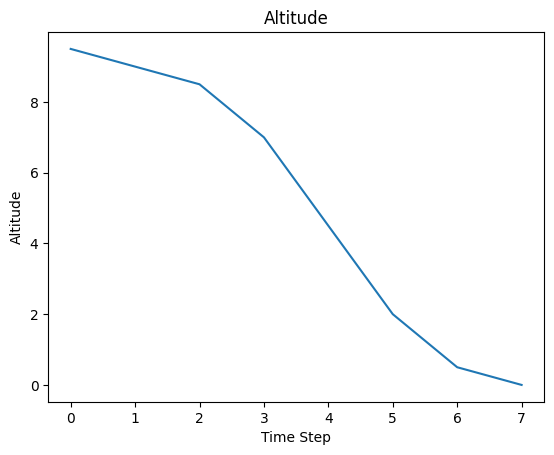

1

In [ ]:
table_agent = TableAgent(memo)

plot_one_game(env, table_agent)


In [ ]:
len(memo)

746

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch

def prepare_data(hash_table):
  # Extract keys (tuples) and values (floats) from the hash table
  keys = np.array(list(hash_table.keys()), dtype = 'float32')
  values0 = np.array(list(hash_table.values()), dtype = 'float32')

  # Reshape the array to have a single column
  values = values0.reshape(-1, 1)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(keys, values, test_size=0.1, random_state=42)

  # Now, split the training data into training (0%) and validation (30%) sets
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

  # convert the tuples into separate arrays
  X_train = np.array(X_train.tolist(), dtype = 'float32')  # Convert tuples to arrays
  X_val = np.array(X_val.tolist(), dtype = 'float32')
  X_test = np.array(X_test.tolist(), dtype = 'float32')

  # Now X_train and X_test are matrices, and y_train and y_test are vectors
  print("X_train shape:", X_train.shape)
  print("X_val shape:", X_val.shape)
  print("X_test shape:", X_test.shape)
  print("y_train shape:", y_train.shape)
  print("y_val shape:", y_val.shape)
  print("y_test shape:", y_test.shape)

  # Convert numpy array to PyTorch tensor using torch.tensor()
  X_train = torch.tensor(X_train)
  X_val = torch.tensor(X_val)
  X_test = torch.tensor(X_test)
  y_train = torch.tensor(y_train)
  y_val = torch.tensor(y_val)
  y_test = torch.tensor(y_test)
  return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(memo)

X_train shape: (603, 4)
X_val shape: (68, 4)
X_test shape: (75, 4)
y_train shape: (603, 1)
y_val shape: (68, 1)
y_test shape: (75, 1)


In [ ]:
def train_once(X_train, y_train):
  model = LanderNetwork()
  # Loss function and optimizer, mean squared error
  criterion = nn.MSELoss()
  #print('parameters', list(model.parameters()))
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  train(X_train, y_train)
  return model


model = train_once(X_train, y_train)

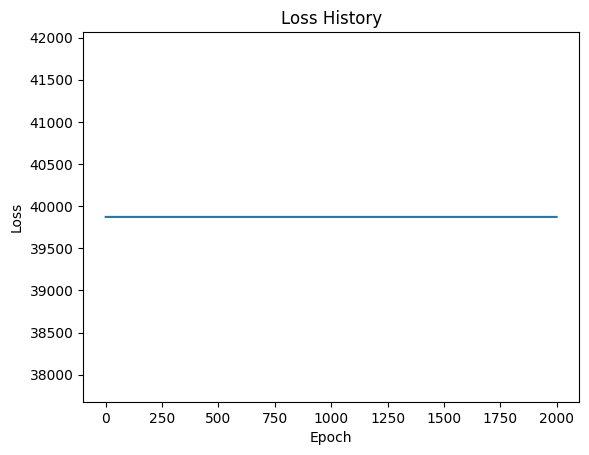

In [ ]:
def train(x, y):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(x)
    loss = criterion(outputs, y)

    # Backward and optimize
    loss.backward()
    optimizer.step()
    return loss


def train_multi_times(episodes, X_train, y_train):
  loss_history = []

  model = LanderNetwork()

  # Loss function and optimizer, mean squared error
  criterion = nn.MSELoss()
  #print('parameters', list(model.parameters()))
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  for i in range(episodes):
    loss = train(X_train, y_train)
    loss = loss.detach().numpy()
    loss_history.append(loss)

  plt.plot(loss_history)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss History')
  plt.show()
  return model
model = train_multi_times(2000, X_train, y_train)

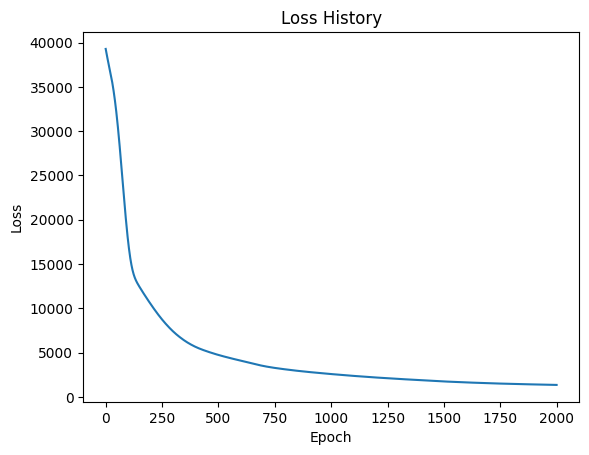

In [ ]:

episodes = 2000
loss_history = []

model = LanderNetwork()

# Loss function and optimizer, mean squared error
criterion = nn.MSELoss()
#print('parameters', list(model.parameters()))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for i in range(episodes):
  loss = train(X_train, y_train)
  loss = loss.detach().numpy()
  loss_history.append(loss)

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()


In [ ]:
def get_recomm(memo):
  firing_dict = {k: memo[k] for k in memo if k[3] == 1}
  falling_dict = {k: memo[k] for k in memo if k[3] == 0}

  # Sort the dictionary based on the first three elements of the keys
  sorted_firing_dict = dict(sorted(firing_dict.items(), key=lambda item: item[0][:3]))
  sorted_falling_dict = dict(sorted(falling_dict.items(), key=lambda item: item[0][:3]))
  # Print the sorted dictionary
  #print(sorted_falling_dict)

  firing_values = np.array([value for value in sorted_firing_dict.values()])
  falling_values = np.array([value for value in sorted_falling_dict.values()])
  recomm = firing_values > falling_values
  return recomm, sorted_firing_dict, sorted_falling_dict

recomm, sorted_firing_dict, sorted_falling_dict = get_recomm(memo)
recomm

array([False, False,  True, False,  True,  True, False,  True, False,
       False,  True, False,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
       False,  True,  True, False,  True, False, False, False, False,
        True,  True, False,  True,  True, False,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False, False, False,  True, False,  True,  True, False,
        True, False, False, False,  True, False,  True, False, False,
        True, False,  True,  True,  True,  True,  True, False, False,
        True, False,  True,  True, False,  True, False, False, False,
        True, False,  True,  True, False,  True,  True, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False,

In [ ]:
def get_predicted_recomm(model, sorted_firing_dict, sorted_falling_dict):
  # Extract keys and convert them into a NumPy array
  X_firing = np.array([key for key in sorted_firing_dict.keys()], dtype='float32')
  X_firing = torch.tensor(X_firing)

  X_falling = np.array([key for key in sorted_falling_dict.keys()], dtype='float32')
  X_falling = torch.tensor(X_falling)

  predicted_y_firing = model(X_firing)
  predicted_y_falling = model(X_falling)

  predicted_recomm0 = predicted_y_firing > predicted_y_falling
  predicted_recomm = predicted_recomm0.numpy().flatten()

  pred_perf = predicted_recomm == recomm
  correct = sum([1 if a==True else 0 for a in pred_perf])
  print(correct, len(sorted_firing_dict))
  return round(correct / len(sorted_firing_dict), 2)

In [ ]:
#model = train_multi_times(2000, X_train, y_train)
get_predicted_recomm(model, sorted_firing_dict, sorted_falling_dict)



240 373


0.64

In [ ]:
model = LanderNetwork()
get_predicted_recomm(model, sorted_firing_dict, sorted_falling_dict)


297 373


0.8

In [ ]:
model = LanderNetwork()
get_predicted_recomm(model, sorted_firing_dict, sorted_falling_dict)


84 373


0.23

In [ ]:
pause

NameError: name 'pause' is not defined

In [ ]:
# 0.478 = (0.9)**n
# log0.478 = n* log0.9
# n = log0.478 / log0.9




In [ ]:
# import math
# math.log(0.478) / math.log(0.9)

In [ ]:
env = One_Dimentional_Lander()

# setting the seed value for reproducability
seed = 100
#env.seed(seed)
#torch.manual_seed(seed)

In [ ]:
class SingleGameReplayBuffer:
  def __init__(self, discount_factor=0.5):
    self.discount_factor = discount_factor # landed with a speed of 0,  1) in 10 steps, bigger reward 2) in 100 steps, less reward
    self.buffer = []

  def logging(self, state, action, reward, next_state):
    self.buffer.append((state, action, reward, next_state))

  def get(self):
    buffer_len = len(self.buffer)
    x = np.zeros((buffer_len, 4), dtype = 'float32')
    y = np.zeros((buffer_len, 1), dtype = 'float32')

    last_state, last_action, last_reward, _ = self.buffer[buffer_len-1]
    #print("last_state", last_state)
    #print("last_action", last_action)
    #print("last_reward", last_reward)

    y[buffer_len-1][0] = last_reward
    x[buffer_len-1] = last_state + [last_action]

    for i in reversed(range(buffer_len-1)):
      current_state, current_action, current_reward, _ = self.buffer[i]
      x[i] = current_state + [current_action]
      y[i][0] = current_reward + (self.discount_factor * y[i+1])
    #print(f'x={x}, y={y}')
    return x, y


  def done(self):
    # state, reward, new_state, action
    get_training_data()
    return training_data




In [ ]:
# replay_buffer = SingleGameReplayBuffer()
# replay_buffer.logging([1, 2, 3], 1, 10.0, [2, 1, 3])
# replay_buffer.logging([4, 2, 1], 0, 5.0, [9, 1, 2])
# replay_buffer.logging([3, 1, 2], 1, 15.0, [0, 1, 2])
# replay_buffer.logging([7, 2, 7], 0, 10.0, [2, 1, 5])

# x, y = replay_buffer.get()
# x, y

In [ ]:
# input is elevation, velocity, fuel
# output is value for each action starting from this state

# input: 3 nodes:
# output: 2 nodes:
# 1) value of not firing the engine = 100
# 2) value of firing the engine = 43


In [ ]:
# prompt: epsilon decay

class Agent:
  def __init__(self, network, epsilon=0.05):
      self.network = network
      self.epsilon = epsilon # explore and exploit. playstart with a big epsilon (explore more)

  def epsilon_greedy(self, state):
    if np.random.rand() < self.epsilon: # whether to explore or exploit
        return np.random.randint(0, 2) # output either 0 or 1
    else:
        return self.greedy(state)


  def greedy(self, state):
      def list_to_tensor(state):
        return torch.tensor(state, dtype=torch.float32)  # Specify the data type as float32

      q_value_0 = self.network(list_to_tensor(state + [0])) # 4 variables
      q_value_1 = self.network(list_to_tensor(state + [1]))
      return 0 if q_value_0 > q_value_1 else 1

  def decay_epsilon(self):
      self.epsilon *= 0.99
      if self.epsilon < 0.005:
        self.epsilon = 0.005


In [ ]:
network = LanderNetwork()
agent = Agent(network)

In [ ]:
# Unit Test

env = One_Dimentional_Lander()
agent = Agent(LanderNetwork(), 0.01)


plot_one_game(env, agent)


In [ ]:
episodes = 100
reinforcement_learn(model, episodes, 0.9, 0.01)

In [ ]:
#input data and converting to torch tensors
inputs = np.array([[73, 67, 43, 34],
                   [91, 88, 64, 54],
                   [87, 134, 58, 65],
                   [102, 43, 37, 65],
                   [69, 96, 70, 90]], dtype = 'float32')
inputs = torch.from_numpy(inputs)


#target data and converting to torch tensors
targets = np.array([[366],[486],[558],[219],[470]], dtype = 'float32')
targets = torch.from_numpy(targets)

# option 1: make the logger responsible in filling
# option 2: during the training, these ones are not available
# option 3: scrap the network, take additional parameter, inputs are state and action, output is the value of that action

# Instantiating the model
model = LanderNetwork()

# Loss function and optimizer, mean squared error
criterion = nn.MSELoss()
#print('parameters', list(model.parameters()))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(inputs, targets)


In [ ]:
import matplotlib.pyplot as plt
envr = One_Dimentional_Lander()
envr.reset(h= 100, vy= 0, fuel= 100)
alt = []
val = []
full = []

for i in range(400):
    v = envr.state[1]
    h = envr.state[0]
    acceleration = v * v / (2 * h)
    if acceleration >= 1:
      envr.step(1)
    else:
      envr.step(0)


    alt.append(envr.state[0])
    val.append(envr.state[1])

    full.append(envr.state[2])
    if envr.landed():
        break


# PID controller: relatively stable speed

In [ ]:
# plot the altitude
plt.plot(alt)
plt.ylabel('Altitude')
plt.xlabel('Time')
plt.show()

In [ ]:
# plot the velocity
plt.plot(val)
plt.ylabel('Velocity')
plt.xlabel('Time')
plt.show()